In [302]:
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import tikzplotlib

In [283]:
def my_bisection(f, a, b, P, tol):
    # approximates a root, R, of f bounded
    # by a and b to within tolerance
    # | f(m) | < tol with m the midpoint
    # between a and b Recursive implementation

    # check if a and b bound a root
    if (f(a) > P and f(b) > P) or (f(a) < P and f(b) < P):
        raise Exception(
         "The scalars a and b do not bound P")

    # get midpoint
    m = (a + b)/2

    if np.abs(f(m)-P) < tol:
        # stopping condition, report m as root
        return m
    elif f(m) > P and f(m) < f(a):
        # case where m is an improvement on a.
        # Make recursive call with a = m
        return my_bisection(f, m, b, P, tol)
    elif f(m) < P and f(m) > f(b):
        # case where m is an improvement on b.
        # Make recursive call with b = m
        return my_bisection(f, a, m, P, tol)

In [284]:
def AWGN_channel(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [285]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [286]:
def sampler(prob, n):
    samples = np.empty(0)
    for idx, p in enumerate(prob):
        occurrences = np.round(n * p)
        samples = np.concatenate((samples, np.ones(occurrences.astype(int)) * idx))
    indexes = np.random.permutation(samples.shape[0])
    return samples[indexes]

In [287]:
def xesmd(apps, idx):
    '''
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    '''
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

In [288]:
n = 100_000
SNR_dBs = np.arange(5,25)

In [311]:
# 16 QAM
M = 4
alphabet = np.arange(-3,4,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

mi_16 = []
for snrdB in SNR_dBs:
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2
    y = AWGN_channel(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_16.append(2*(2 - xe / np.log(2)))

In [312]:
# 64 QAM
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

print('Power: ',np.mean(np.square(symbols)))

mi_64 = []
for snrdB in SNR_dBs:
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2
    y = AWGN_channel(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))

Power:  0.9957104761904764


MB Distribution

In [291]:
def power_for_shaping(shaping):
    alphabet = np.arange(-7,8,2)
    # alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
    scaling = (alphabet[1]-alphabet[0])/2

    denominator = np.sum(np.exp(-shaping*np.square(alphabet)))
    probs = 1/denominator * np.exp(-shaping*np.square(alphabet))

    power = np.sum(np.square(np.arange(-7,8,2)*(scaling))*probs)
    return power

In [292]:
# P = 5
# p1 = my_bisection(power_for_shaping, 0.1, 0.8, P, 0.1)
# print("P1 =", p1)

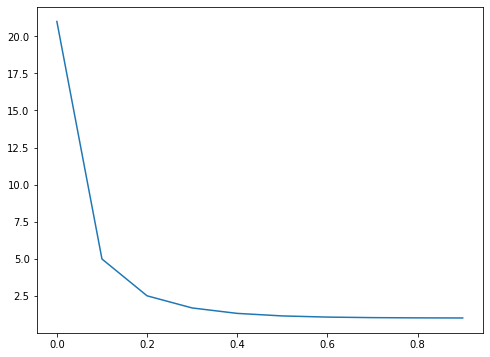

In [293]:
power = []
for i in np.arange(0,1,0.1):
    power.append(power_for_shaping(i))

plt.plot(np.arange(0,1,0.1), power)

Scaling:  0.21821789023599236
Power:  0.19981281640460036
Scaling:  0.488178537485942
Entropy:  2.081541604955408
Power:  0.9999835216021884


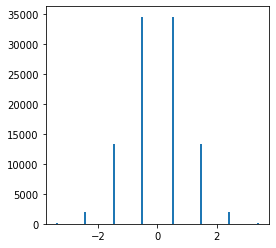

In [294]:
M = 8
shaping = 2.5
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
scaling = (alphabet[1]-alphabet[0])/2
scaling = 0.21821789023599236
print('Scaling: ', scaling)

denominator = np.sum(np.exp(-shaping*np.square(alphabet)))
probs = 1/denominator * np.exp(-shaping*np.square(alphabet))

power = np.sum(np.square(np.arange(-7,8,2)*(scaling))*probs)
print('Power: ', power)

indices = sampler(probs, n).astype(int)
norm_factor = np.sqrt(np.sum(np.square(alphabet) * probs))
alphabet =  alphabet / norm_factor
symbols = alphabet[indices]
scaling = (alphabet[1]-alphabet[0])/2
print('Scaling: ', scaling)


H = np.sum(-np.log2(probs)*probs)
print('Entropy: ',H)
power = np.mean(symbols**2)
print('Power: ', power)
plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(symbols, bins=100)
plt.show()


In [295]:
mi_mb_64 = []
for snrdB in SNR_dBs:
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2
    y = AWGN_channel(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_mb_64.append((H - (xe) / np.log(2)))

In [313]:
# 256 QAM
M = 16
alphabet = np.arange(-15,16,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

print('Power: ',np.mean(np.square(symbols)))

mi_256 = []
for snrdB in SNR_dBs:
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2
    y = AWGN_channel(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_256.append(2*(4 - (xe) / np.log(2)))

Power:  1.0031529411764706


Text(0.5, 0, 'SNR in dB')

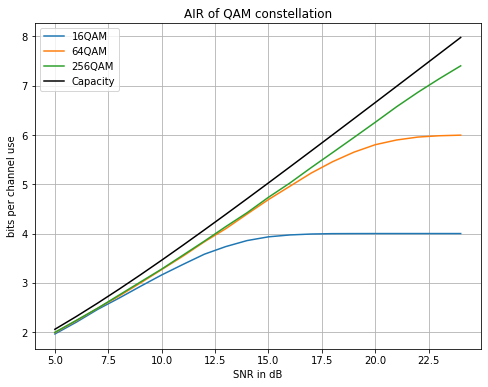

In [328]:
# Plot
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(SNR_dBs, mi_16, label = '16QAM')
plt.plot(SNR_dBs, mi_64, label = '64QAM')
# plt.plot(SNR_dBs, mi_mb_64, label = '64-MB')
plt.plot(SNR_dBs, mi_256, label = '256QAM')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='Capacity')
plt.legend()
plt.grid()
plt.title('AIR of QAM constellation')
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')
# tikzplotlib.save("QAM_MI.tex")

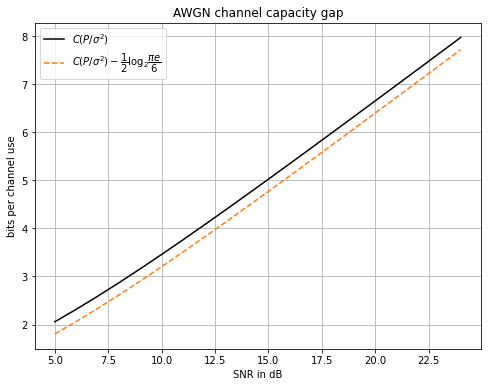

In [329]:
SNR_dBs = np.arange(5,25)
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='$C(P/\sigma^2)$')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)) - 0.5*np.log2((np.pi*np.e)/6) , linestyle='dashed', color='C1', label='$C(P/\sigma^2) - \dfrac{1}{2}\log_2\dfrac{\pi e}{6}$')
plt.grid()
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')
# plt.xlim([5, 25])
# plt.ylim([1, 8])
plt.title('AWGN channel capacity gap')
plt.legend()
# tikzplotlib.save("SNR_GAP.tex")

# Bisection Method

In [298]:
f = lambda x: -np.log10(x)
P = 0.4
p1 = my_bisection(f, 0.2, 0.8, P, 0.1)
print("P1 =", p1)
p01 = my_bisection(f, 0.2, 0.8, P, 0.01)
print("P01 =", p01)

print("f(r1) =", f(p1))
print("f(r01) =", f(p01))

P1 = 0.5
P01 = 0.40625
f(r1) = 0.3010299956639812
f(r01) = 0.3912066260130692
